# Saves Analysis

### MSP, 4.21.2017

A struggle to understand exactly what we can use, apart from manager proclamations, to understand save propensity.

In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl


%matplotlib inline

In [24]:
# read in fangraphs-ripped stats. specifications:
#    fangraphs-denoted starter


def read_individual_standard_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","W","L","ERA","G","GS","CG","ShO",\
                                   "SV","HLD","BS","IP","TBF","H","R","ER","HR","BB",\
                                   "IBB","HBP","WP","BK","SO","playerid"),\
                         'formats': ('S20','S20','f4','f4','f4','f4','f4','f4','f4',\
                                    'i2','i2','i2','f4','i2','i2','i2','i2','i2','f4',\
                                    'f4','f4','f4','f4','f4','i4')},\
                 skip_header=1,delimiter=',')

def read_individual_battedball_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","BABIP","GB/FB","LD","GB","FB","IFFB","HRFB",\
                                   "RS","RS9","BLLS","STRKS","PIT","PULL","CENT","OPPO",\
                                   "SOFT","MED","HARD","playerid"),\
                         'formats': ('S20','S20','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','i4')},\
                 skip_header=1,delimiter=',')


def read_individual_pfraction_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","IP",\
                                   "FA","FT","FC","FS","FO",\
                                   "SI","SL","CU","KC","EP",\
                                   "CH","SC","KN","UN","playerid"),\
                         'formats': ('S20','S20','f4',\
                                    'f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','i4')},\
                    skip_header=1,delimiter=',',filling_values=0.)

def read_individual_pvel_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","IP",\
                                   "vFA","vFT","vFC","vFS","vFO",\
                                   "vSI","vSL","vCU","vKC","vEP",\
                                   "vCH","vSC","vKN","playerid"),\
                         'formats': ('S20','S20','f4',\
                                    'f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','i4')},\
                    skip_header=1,delimiter=',',filling_values=0.)


RelieversPlayers2016 = read_individual_standard_stats('2016Pitching/Relievers2016.csv')
RelieversBatted2016  = read_individual_battedball_stats('2016Pitching/RelieversBatted2016.csv')

RelieversPitches2016 = read_individual_pfraction_stats('2016Pitching/RelieversPitchFractions.csv')
RelieversVelo2016 = read_individual_pvel_stats('2016Pitching/RelieversPitchVels.csv')




How does one succeed at being a closer?

How many saves can someone get?

In [29]:

#
# calculate some extra stats
#

#FIP = ((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant


SP2016FIP  = (13.*RelieversPlayers2016['HR'] +\
              (3.*(RelieversPlayers2016['BB'] + RelieversPlayers2016['HBP'])) -\
              2.*RelieversPlayers2016['SO'])\
                /RelieversPlayers2016['IP'] + 3.1437 # 3.143 is the 2016 correction
    
SP2016WHIP = (RelieversPlayers2016['BB'] + RelieversPlayers2016['H'])/RelieversPlayers2016['IP']
SP2016HIP = (RelieversPlayers2016['H'])/RelieversPlayers2016['IP']




In [77]:


#
# match the player stats across datasets
#
PlayerDict = {}
PlayerDict['Player'] = RelieversPlayers2016['Name']
PlayerDict['WHIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['BABIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['FIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['HIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['ERA'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['ST'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['fFA'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['fSS'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['vFA'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['vSS'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['SV'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['TSV'] = np.zeros(len(RelieversPlayers2016['Name']))




#
# also add a 100 IP threshold
#
for x in range(0,len(PlayerDict['Player'])):
    if RelieversPlayers2016['IP'][x] > 40.:
        PlayerDict['WHIP'][x] = SP2016WHIP[x]
        PlayerDict['FIP'][x] = SP2016FIP[x]
        PlayerDict['HIP'][x] = SP2016HIP[x]
        PlayerDict['ERA'][x] = RelieversPlayers2016['ERA'][x]
        PlayerDict['SV'][x] = RelieversPlayers2016['SV'][x]/RelieversPlayers2016['G'][x]
        PlayerDict['TSV'][x] = RelieversPlayers2016['SV'][x]
        # block for velocities
        xx = np.where(RelieversPlayers2016['Name'][x] == RelieversPitches2016['Name'])[0]
        try:
            PlayerDict['fFA'][x] = \
              RelieversPitches2016['FA'][xx] + RelieversPitches2016['FT'][xx] + \
                RelieversPitches2016['FC'][xx] + RelieversPitches2016['FS'][xx] + \
                RelieversPitches2016['FO'][xx]
            PlayerDict['vFA'][x] = \
              np.max([RelieversVelo2016['vFA'][xx],RelieversVelo2016['vFT'][xx],RelieversVelo2016['vFC'][xx],RelieversVelo2016['vFS'][xx],RelieversVelo2016['vFO'][xx]])
            PlayerDict['fSS'][x] = \
              RelieversPitches2016['SI'][xx] + RelieversPitches2016['SL'][xx]
            PlayerDict['vSS'][x] = \
              np.max([RelieversVelo2016['vSI'][xx],RelieversVelo2016['vSL'][xx]])

        except:
            PlayerDict['FA'][x] = np.nan
            PlayerDict['vFA'][x] = np.nan
            PlayerDict['SS'][x] = np.nan
            PlayerDict['vSS'][x] = np.nan
            
        try:
            xx = np.where(RelieversPlayers2016['Name'][x] == RelieversBatted2016['Name'])[0]
            PlayerDict['BABIP'][x] = \
              RelieversBatted2016['BABIP'][xx]
            PlayerDict['ST'][x] = RelieversBatted2016['STRKS'][xx]/RelieversBatted2016['PIT'][xx]
        except:
            PlayerDict['BABIP'][x] = np.nan
            PlayerDict['ST'][x] = np.nan
            
        
    else:
        PlayerDict['WHIP'][x] = np.nan
        PlayerDict['FIP'][x] = np.nan
        PlayerDict['HIP'][x] = np.nan
        PlayerDict['BABIP'][x] = np.nan

Alright, let's get a couple things straight first by looking at the distribution of saves in 2016. 90 guys got 1+ save, but only 12 got 32+. In fact, looking at the cumulative distribution, the top 12 closers got 50% of the available saves--and no league has 100% save efficiency (the guys who are down below 5 are unlikely to ever be owned).

In fact, we can take a stab at estimating what the save efficiency in a league is by looking at the saves-per-appearance plot. Going off gut feeling, I'd say it's unlikely that guys who get less than 1 save per 10 appearances are owned, which according to the cumulative distribution function, suggests that almost 20% of the saves in the MLB go unrecorded in the average fantasy league. Damn.

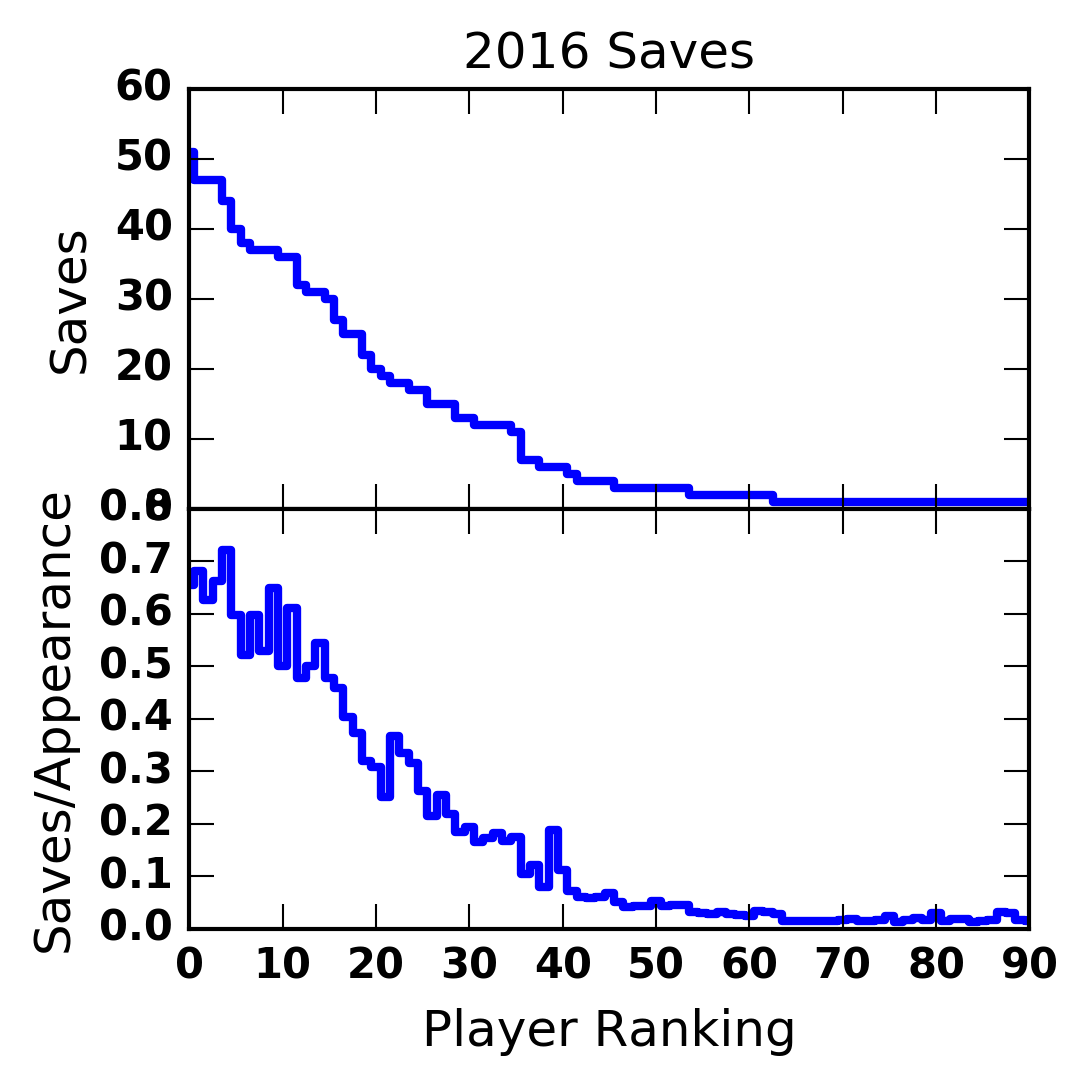

In [78]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_axes([0.15,0.5,0.7,0.35])
ax2 = fig.add_axes([0.15,0.15,0.7,0.35])




ax2.plot(PlayerDict['SV'][(-1.*PlayerDict['TSV']).argsort()[0:91]],drawstyle='steps-mid')
ax2.set_ylabel('Saves/Appearance',size=12)
ax2.set_xlabel('Player Ranking',size=12)



ax.plot(PlayerDict['TSV'][(-1.*PlayerDict['TSV']).argsort()[0:91]],drawstyle='steps-mid')
ax.set_ylabel('Saves',size=12)
ax.set_title('2016 Saves')
_ = ax.set_xticklabels(())




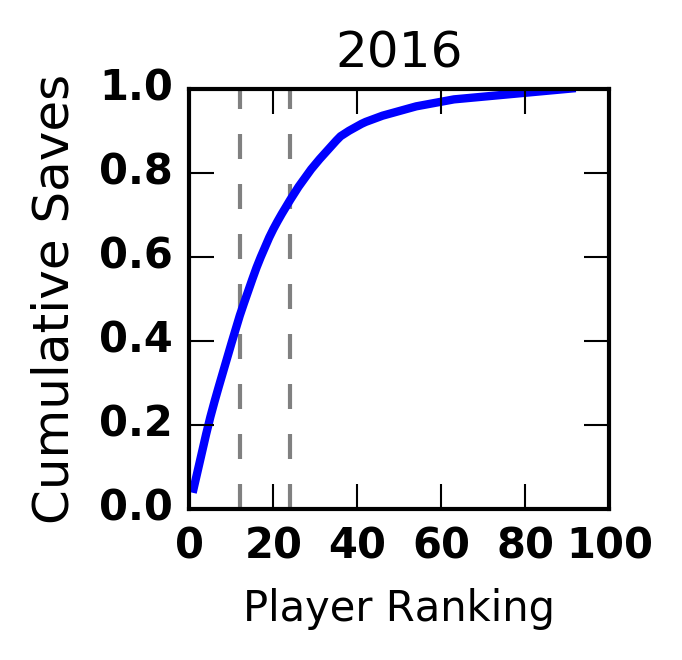

In [79]:
fig = plt.figure(figsize=(2,2))

ax = fig.add_axes([0.15,0.5,0.7,0.7])

ax.plot([12,12],[0.,1.],color='gray',lw=1.,linestyle='dashed')
ax.plot([24,24],[0.,1.],color='gray',lw=1.,linestyle='dashed')



ax.plot(np.arange(1,92,1),np.cumsum(PlayerDict['TSV'][(-1.*PlayerDict['TSV']).argsort()[0:91]])/np.sum(PlayerDict['TSV']))
ax.set_ylabel('Cumulative Saves',size=12)
ax.set_title('2016',size=12)


_ = ax.set_xlabel('Player Ranking')



In [89]:
print(np.max([PlayerDict['vFA'],PlayerDict['vSS']],axis=0))

[  88.69999695   92.5          92.09999847   97.69999695   93.30000305
   91.30000305   89.69999695   94.19999695   96.19999695   97.09999847
   92.40000153   94.59999847   93.           90.90000153   96.
   94.80000305   97.19999695   92.40000153   83.90000153   89.30000305
   89.           96.80000305   92.80000305   90.40000153   90.19999695
   94.69999695   90.80000305   91.80000305   96.69999695   95.69999695
   91.09999847   92.30000305   91.80000305   94.5          95.40000153
   95.40000153   94.19999695   94.09999847   96.19999695   92.30000305
   85.40000153   92.5          89.30000305   92.40000153   94.30000305
   98.19999695   92.30000305   92.19999695   96.09999847   92.09999847
   89.90000153   90.09999847   94.90000153   93.19999695   95.
   93.09999847   92.59999847   92.90000153   91.90000153   93.80000305
   98.69999695   95.69999695   98.           89.80000305   91.80000305
   92.80000305   94.5          93.90000153   92.19999695   93.40000153
   95.59999847   90.80

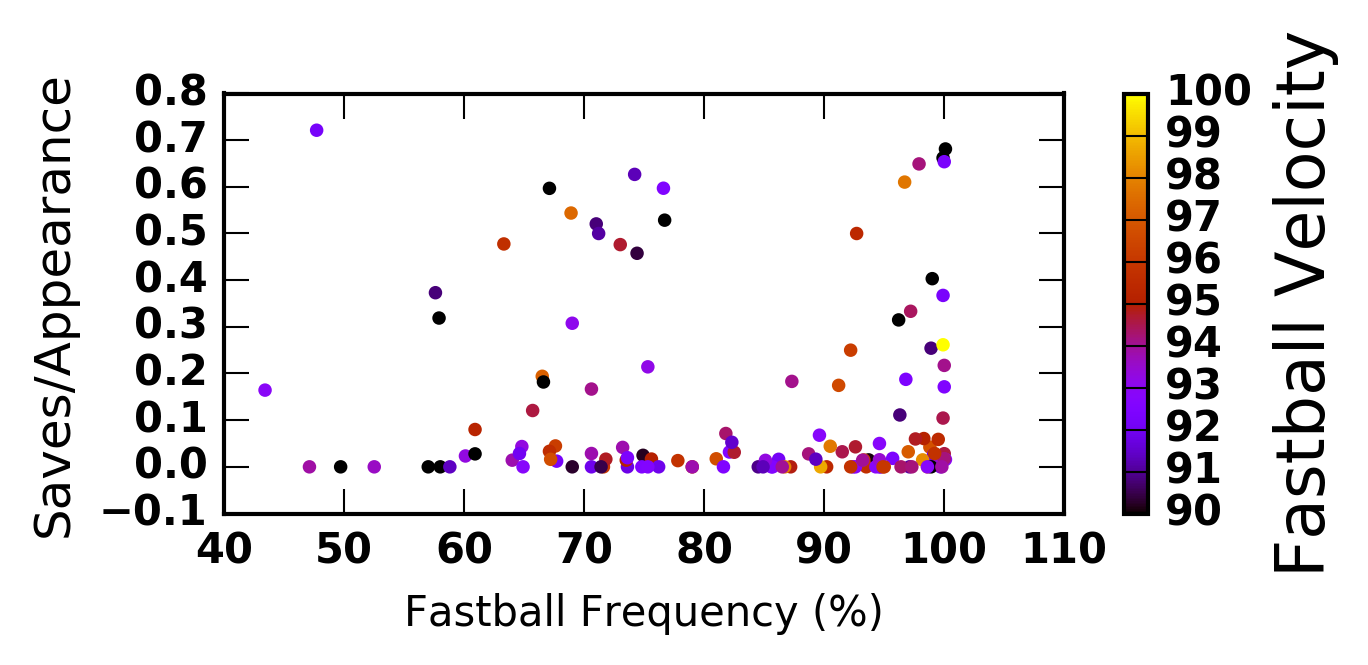

In [94]:

fig = plt.figure(figsize=(4,2))

ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

# find valid values and plot
ax.scatter(PlayerDict['fFA']+PlayerDict['fSS'],PlayerDict['SV'],\
            color=cm.gnuplot((np.max([PlayerDict['vFA'],PlayerDict['vSS']],axis=0) - 90.)/10.,1.),s=5.)

ax.set_ylabel('Saves/Appearance',size=12)
ax.set_xlabel('Fastball Frequency (%)')


cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=90., vmax=100.)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Fastball Velocity',size=16)




In [42]:
print PlayerDict['Player'][np.where(PlayerDict['vFA']==0.)]
print RelieversPitches2016[np.where(RelieversPitches2016['Name']=='Brad Ziegler')]


['Brad Ziegler' 'Alex Claudio' 'Tony Watson' 'J.P. Howell']
[ ('Brad Ziegler', '- - -', 68.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.900001525878906, 0.0, 18.0, 0.0, 0.0, 24.100000381469727, 0.0, 0.0, 0.0, 7293)]


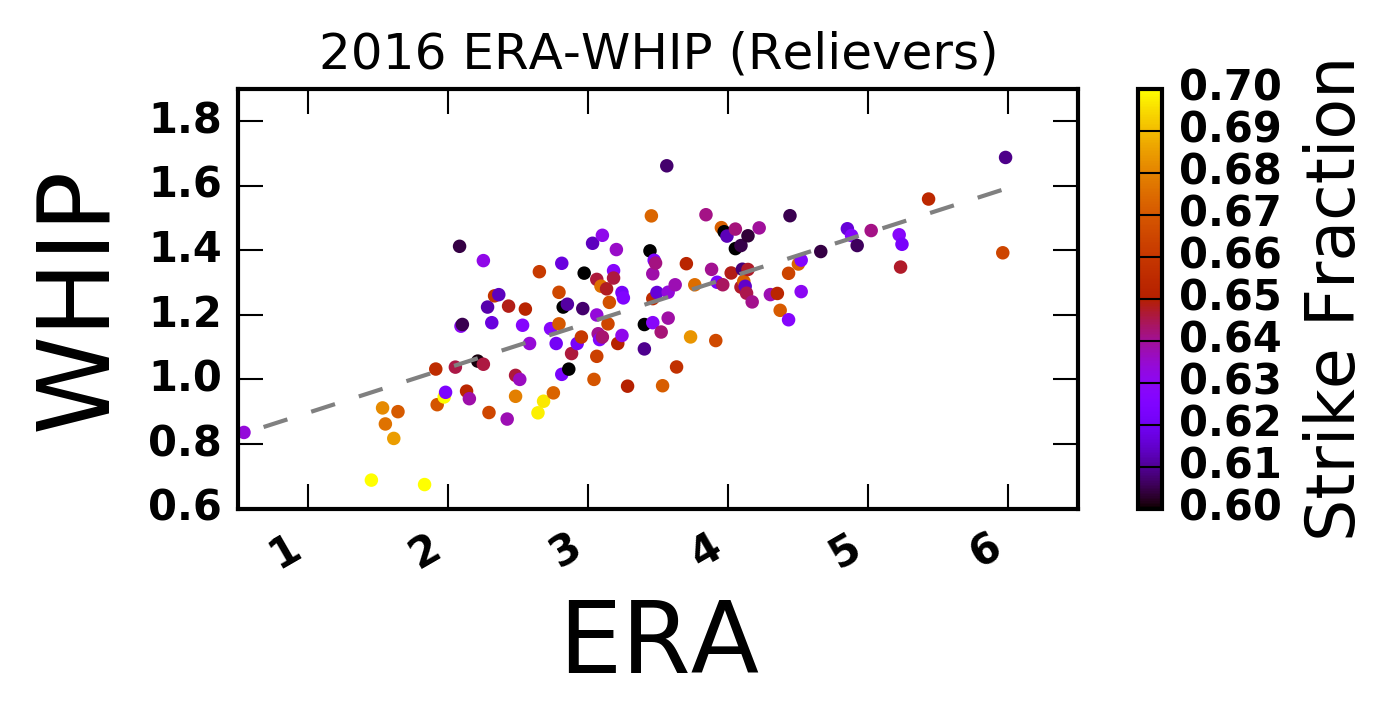

In [8]:

fig = plt.figure(figsize=(4,2))

ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

# find valid values and plot
goodw = np.where(PlayerDict['BABIP'] > 0.)[0]
ax.scatter(PlayerDict['ERA'][goodw],PlayerDict['WHIP'][goodw],\
            color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)


ax.axis([0.5,6.5,0.6,1.9])
ax.set_ylabel('WHIP',size=24)
ax.set_xlabel('ERA',size=24)
for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")

ax.set_title('2016 ERA-WHIP (Relievers)')



# fit a linear model to valid values
goodw = np.where(PlayerDict['ERA'] > 0.)[0]
c = np.polyfit(PlayerDict['ERA'][goodw],PlayerDict['WHIP'][goodw],1)
d = np.poly1d(c)
ax.plot(np.linspace(0.0,6.0,100),d(np.linspace(0.0,6.0,100)),color='gray',lw=1.,linestyle='dashed')

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=16)





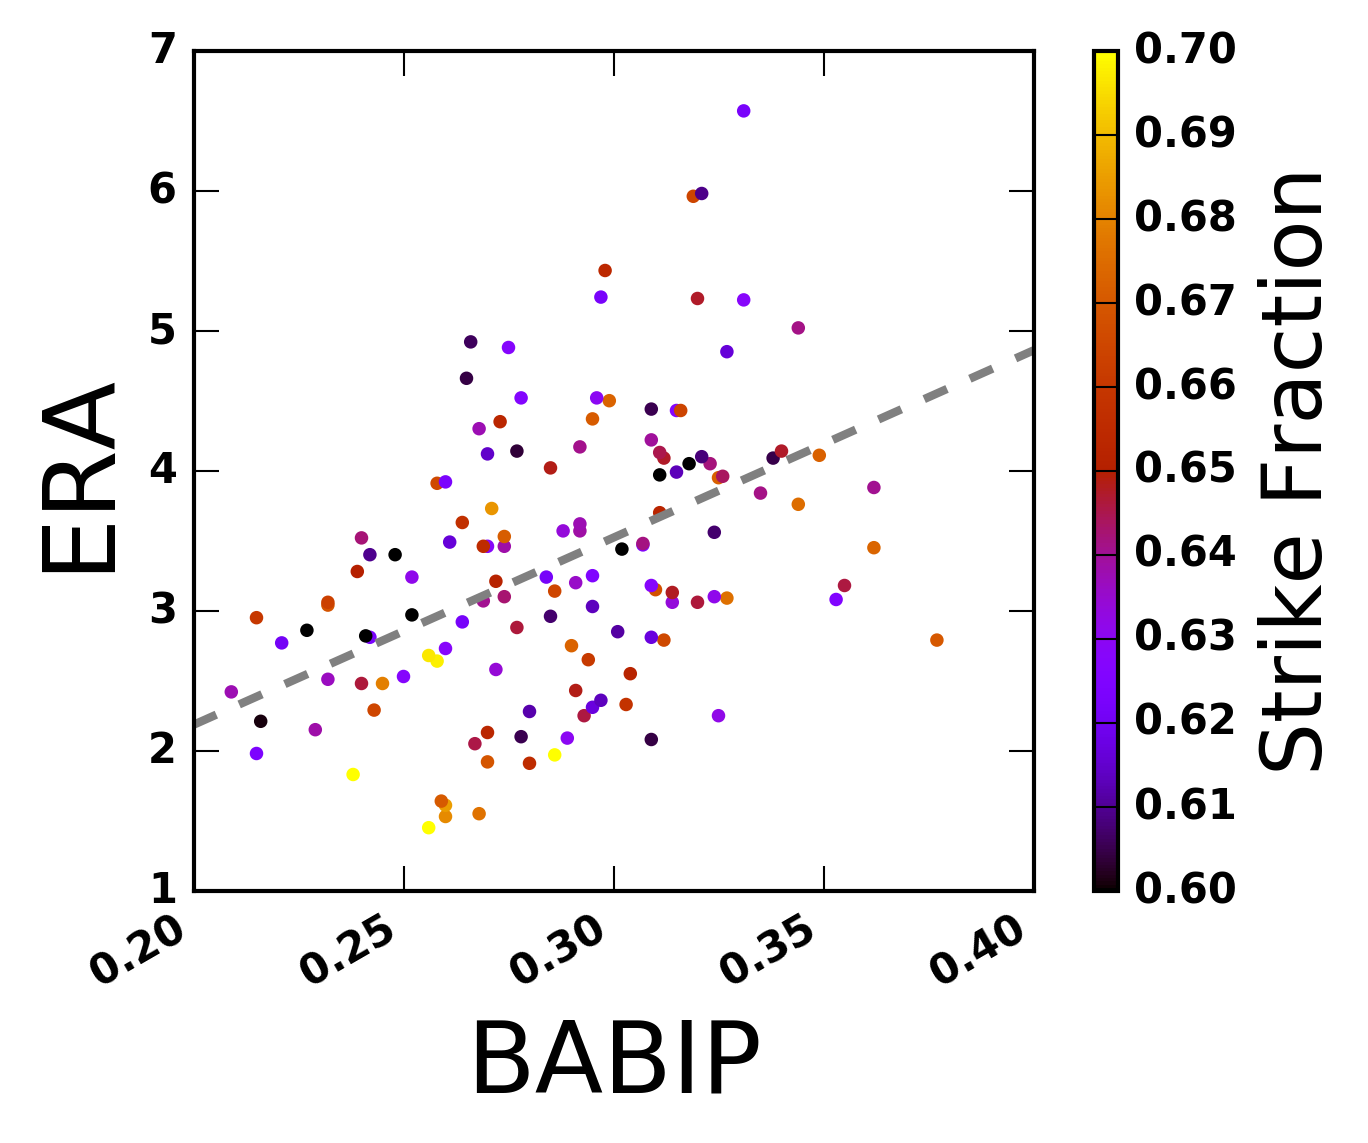

In [9]:


fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

# find only pitchers with batted ball data
goodw = np.where(PlayerDict['BABIP'] > 0.)[0]

ax.scatter(PlayerDict['BABIP'][goodw],PlayerDict['ERA'][goodw],\
           color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)

c = np.polyfit(PlayerDict['BABIP'][goodw],PlayerDict['ERA'][goodw],1)
d = np.poly1d(c)

ax.plot(np.linspace(.2,.4,100),d(np.linspace(.2,.4,100)),color='gray',linestyle='dashed')

ax.axis([0.2,0.4,1.,7.])
ax.set_ylabel('ERA',size=24)
ax.set_xlabel('BABIP',size=24)

for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")


The next step is to set up the regression to see what we might expect from players going forward. I've already fit a simple linear model in the figure above, so let's use it to look at outliers:

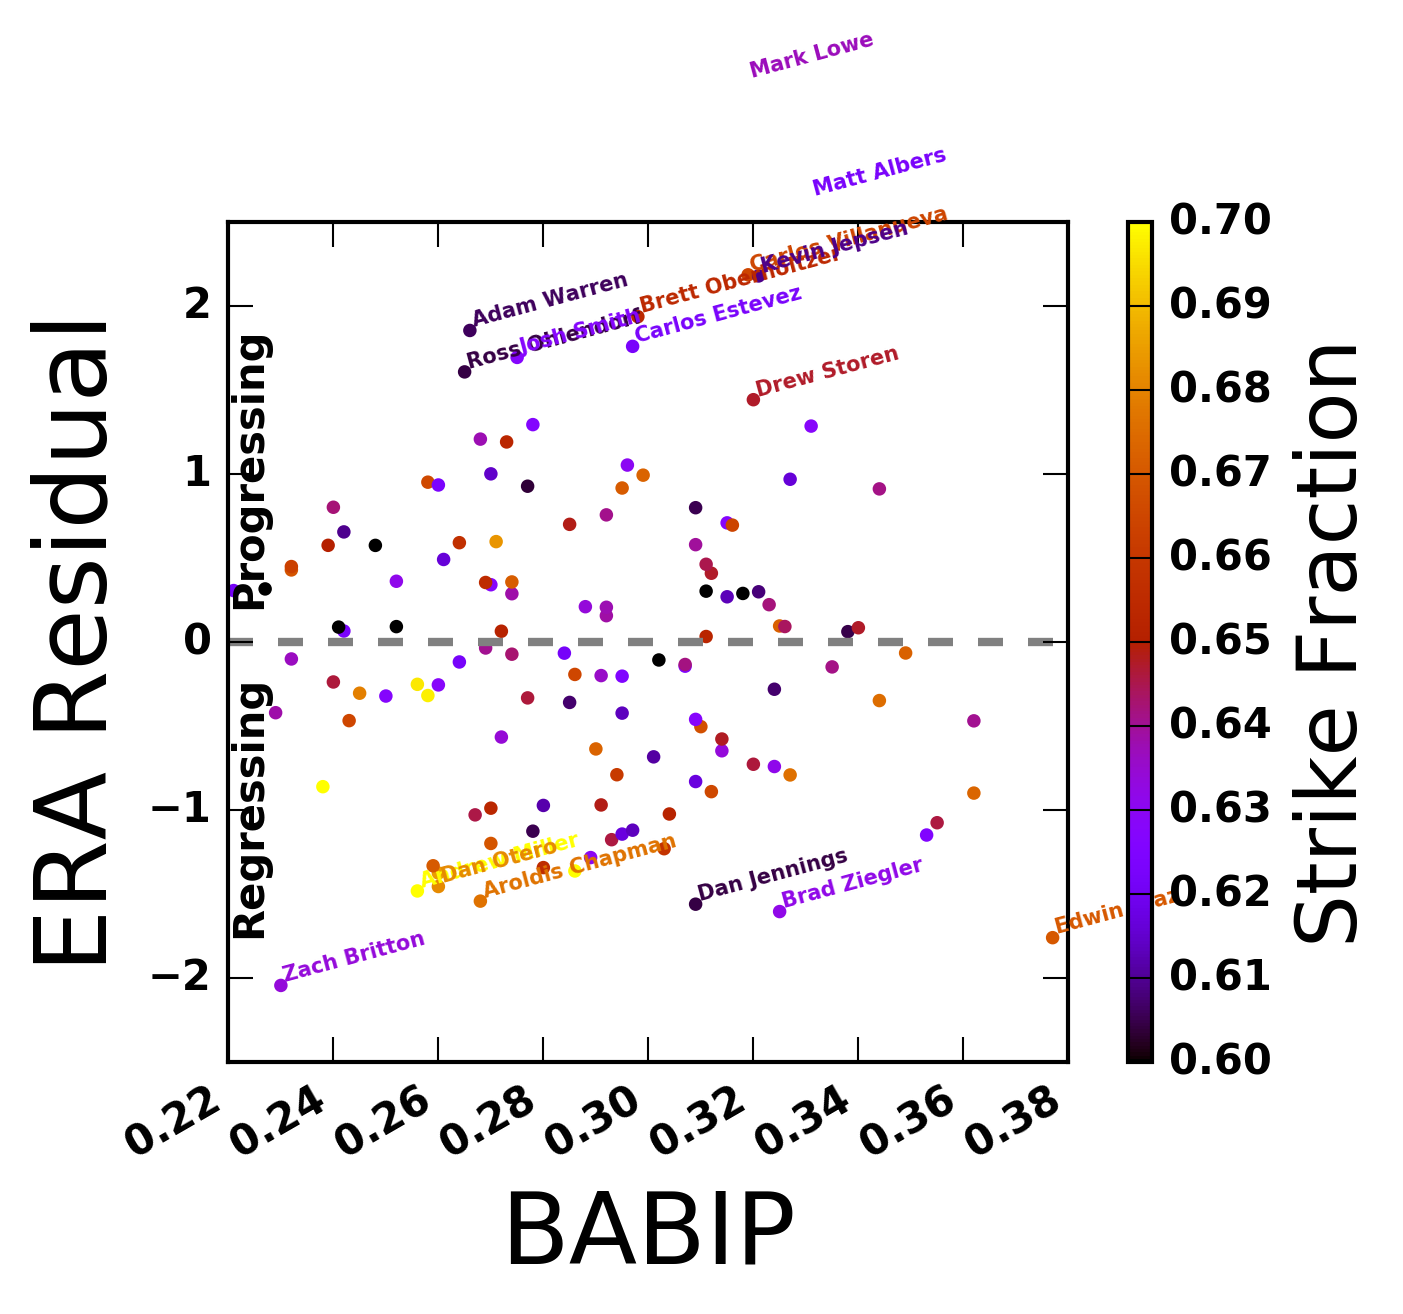

In [10]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


goodw = np.where(PlayerDict['BABIP'] > 0.)[0]



model = PlayerDict['ERA'][goodw] - d(PlayerDict['BABIP'][goodw])
cbar = ax.scatter(PlayerDict['BABIP'][goodw],model,\
                  color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)

ax.plot([0.22,0.38],[0.,0.],color='gray',linestyle='dashed')

ax.axis([0.22,0.38,-2.5,2.5])
ax.set_xlabel('BABIP',size=24)
ax.set_ylabel('ERA Residual',size=24)
ax.text(0.22,-0.2,'Regressing',rotation=90,va='top')
ax.text(0.22,0.2,'Progressing',rotation=90,va='bottom')

for indx in goodw:
    modval = PlayerDict['ERA'][indx] - d(PlayerDict['BABIP'][indx])
    if (PlayerDict['BABIP'][indx] > 0.0) & (modval > 1.36):
        ax.text(PlayerDict['BABIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx]-0.6)/0.1,1.))
    if (PlayerDict['BABIP'][indx] > 0.0) & (modval < -1.4):
        ax.text(PlayerDict['BABIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx] -0.6)/0.1,1.))


cmap = mpl.cm.gnuplot
norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")